In [23]:
# Imports and stuff

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Preparing the data

In [24]:
auction_2018 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2018.csv')
auction_2018.set_index('Player', inplace=True)

# The following stats are calculates across two year intervals
# so, ipl_stats_1 contains stats calculated across the 2016 and 2017 seasons
# and ipl_stats_2 contains contains stats calculated across the 2008 to 2017 seasons
# For the it20 stats, the same follows, except the time intervals
# end the day before the auction of the 2018 ipl season

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2016_2017.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2017.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2016_2017.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2017.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
if 'Played For Country' in ipl_stats_1.columns:
    ipl_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in ipl_stats_2.columns:
    ipl_stats_2.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_1.columns:
    it20_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_2.columns:
    it20_stats_2.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Merging the dataframes
data_2018 = pd.concat([auction_2018, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)


print(data_2018.columns)
data_2018.head()

Index(['Role', 'Amount', 'Team', 'Year', 'Player Origin', 'dob',
       'Played For Country', 'ipl 1 runs', 'ipl 1 balls', 'ipl 1 4s',
       'ipl 1 6s', 'ipl 1 batting SR', 'ipl 1 batting average',
       'ipl 1 times dismissed', 'ipl 1 balls bowled', 'ipl 1 runs conceded',
       'ipl 1 wickets', 'ipl 1 economy', 'ipl 1 bowling average',
       'ipl 1 bowling SR', 'ipl 1 overs bowled', 'ipl 1 wides',
       'ipl 1 noballs', 'ipl 2 runs', 'ipl 2 balls', 'ipl 2 4s', 'ipl 2 6s',
       'ipl 2 batting SR', 'ipl 2 batting average', 'ipl 2 times dismissed',
       'ipl 2 balls bowled', 'ipl 2 runs conceded', 'ipl 2 wickets',
       'ipl 2 economy', 'ipl 2 bowling average', 'ipl 2 bowling SR',
       'ipl 2 overs bowled', 'ipl 2 wides', 'ipl 2 noballs', 'it20 1 runs',
       'it20 1 balls', 'it20 1 4s', 'it20 1 6s', 'it20 1 batting SR',
       'it20 1 batting average', 'it20 1 times dismissed',
       'it20 1 balls bowled', 'it20 1 runs conceded', 'it20 1 wickets',
       'it20 1 economy', 

,Role,Amount,Team,Year,Player Origin,dob,Played For Country,ipl 1 runs,ipl 1 balls,ipl 1 4s,...,it20 2 times dismissed,it20 2 balls bowled,it20 2 runs conceded,it20 2 wickets,it20 2 economy,it20 2 bowling average,it20 2 bowling SR,it20 2 overs bowled,it20 2 wides,it20 2 noballs
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Finch,Batsman,62000000,Kings XI Punjab,2018.0,Overseas,1986-11-17,1.0,692.0,473.0,70.0,...,27.0,6.0,9.0,0.0,9.0,NaN,NaN,1.0,0.0,0.0
Abhishek Sharma,All-Rounder,5500000,Delhi Daredevils,2018.0,Indian,2000-09-04,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aditya Tare,Wicket Keeper,2000000,Mumbai Indians,2018.0,Indian,1987-11-07,0.0,26.0,38.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ajinkya Rahane,Batsman,40000000,Rajasthan Royals,2018.0,Indian,1988-06-06,1.0,862.0,701.0,89.0,...,17.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
Akila Dhananjaya,Bowler,5000000,Mumbai Indians,2018.0,Overseas,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Now let's convert DOB to age at time of auction

auction_date = pd.to_datetime('2018-01-27')
data_2018['Age'] = (auction_date - pd.to_datetime(data_2018['dob'])).dt.days // 365

# Drop the DOB column
data_2018.drop('dob', axis=1, inplace=True)

# I'm just going to replace missing ages with the mean age (for now at least)
data_2018['Age'].fillna(data_2018['Age'].mean(), inplace=True)

print(data_2018['Age'].describe())

count    169.000000
mean      26.944056
std        4.579686
min       17.000000
25%       25.000000
50%       26.944056
75%       29.000000
max       43.000000
Name: Age, dtype: float64


In [26]:
# Deal with missing values
data_2018.fillna(0, inplace=True)
data_2018.isnull().sum()

Role                   0
Amount                 0
Team                   0
Year                   0
Player Origin          0
                      ..
it20 2 bowling SR      0
it20 2 overs bowled    0
it20 2 wides           0
it20 2 noballs         0
Age                    0
Length: 71, dtype: int64

In [27]:
# Drop the 'Team' column
data_2018.drop('Team', axis=1, inplace=True)

# Add dummy variables for 'Role' and 'Player Origin'
data_2018 = pd.get_dummies(data_2018, columns=['Role', 'Player Origin'])

In [28]:
auction_2019 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2019.csv')
auction_2019.set_index('Player', inplace=True)

# The following stats are calculates across two year intervals
# so, ipl_stats_1 contains stats calculated across the 2016 and 2017 seasons
# and ipl_stats_2 contains stats calculated across the 2014 and 2015 seasons
# For the it20 stats, the same follows, except the two year interval\
# ends the day before the auction of the 2018 ipl season

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2017_2018.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2018.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2017_2018.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2018.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
if 'Played For Country' in ipl_stats_1.columns:
    ipl_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in ipl_stats_2.columns:
    ipl_stats_2.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_1.columns:
    it20_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_2.columns:
    it20_stats_2.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Merging the dataframes
data_2019 = pd.concat([auction_2019, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

data_2019.head()

,Role,Amount,Team,Year,Player Origin,Played For Country,dob,ipl 1 runs,ipl 1 balls,ipl 1 4s,...,it20 2 times dismissed,it20 2 balls bowled,it20 2 runs conceded,it20 2 wickets,it20 2 economy,it20 2 bowling average,it20 2 bowling SR,it20 2 overs bowled,it20 2 wides,it20 2 noballs
Player,,,,,,,,,,,,,,,,,,,,,
Agnivesh Ayachi,All-Rounder,2000000,Kings XI Punjab,2019.0,Indian,0.0,1995-06-15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akshdeep Nath,All-Rounder,36000000,Royal Challengers Bangalore,2019.0,Indian,0.0,1993-05-10,9.0,14.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ankush Bains,Wicket Keeper,2000000,Delhi Capitals,2019.0,Indian,0.0,1995-12-16,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anmolpreet Singh,Batsman,8000000,Mumbai Indians,2019.0,Indian,0.0,1998-03-28,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anrich Nortje,Bowler,2000000,Kolkata Knight Riders,2019.0,Overseas,0.0,1993-11-16,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Now let's convert DOB to age at time of auction

auction_date = pd.to_datetime('2018-12-18')
data_2019['Age'] = (auction_date - pd.to_datetime(data_2019['dob'])).dt.days // 365

# Drop the DOB column
data_2019.drop('dob', axis=1, inplace=True)

# I'm just going to replace missing ages with the mean age (for now at least)
data_2019['Age'].fillna(data_2019['Age'].mean(), inplace=True)

print(data_2019['Age'].describe())

count    60.000000
mean     25.392157
std       4.337766
min      17.000000
25%      22.750000
50%      25.392157
75%      28.000000
max      35.000000
Name: Age, dtype: float64


In [30]:
# Deal with missing values
data_2019.fillna(0, inplace=True)
data_2019.isnull().sum()

Role                   0
Amount                 0
Team                   0
Year                   0
Player Origin          0
                      ..
it20 2 bowling SR      0
it20 2 overs bowled    0
it20 2 wides           0
it20 2 noballs         0
Age                    0
Length: 71, dtype: int64

In [31]:
# Drop the 'Team' column
data_2019.drop('Team', axis=1, inplace=True)

# Add dummy variables for 'Role' and 'Player Origin'
data_2019 = pd.get_dummies(data_2019, columns=['Role', 'Player Origin'])

In [32]:
auction_2020 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2020.csv')
auction_2020.set_index('Player', inplace=True)

# The following stats are calculates across two year intervals
# so, ipl_stats_1 contains stats calculated across the 2016 and 2017 seasons
# and ipl_stats_2 contains stats calculated across the 2014 and 2015 seasons
# For the it20 stats, the same follows, except the two year interval\
# ends the day before the auction of the 2018 ipl season

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2018_2019.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2019.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2018_2019.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2019.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
if 'Played For Country' in ipl_stats_1.columns:
    ipl_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in ipl_stats_2.columns:
    ipl_stats_2.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_1.columns:
    it20_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_2.columns:
    it20_stats_2.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Merging the dataframes
data_2020 = pd.concat([auction_2020, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

data_2020.head()

,Role,Amount,Team,Year,Player Origin,Played For Country,dob,ipl 1 runs,ipl 1 balls,ipl 1 4s,...,it20 2 times dismissed,it20 2 balls bowled,it20 2 runs conceded,it20 2 wickets,it20 2 economy,it20 2 bowling average,it20 2 bowling SR,it20 2 overs bowled,it20 2 wides,it20 2 noballs
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Finch,Batsman,44000000,Royal Challengers Bangalore,2020.0,Overseas,1.0,1986-11-17,134.0,100.0,6.0,...,45.0,6.0,9.0,0.0,9.00,NaN,NaN,1.00,0.0,0.0
Abdul Samad,All-Rounder,2000000,Sunrisers Hyderabad,2020.0,Indian,0.0,2004-06-15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akash Singh,Bowler,2000000,Rajasthan Royals,2020.0,Indian,0.0,1995-12-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alex Carey,Wicket Keeper,24000000,Delhi Capitals,2020.0,Overseas,1.0,1991-08-27,NaN,NaN,NaN,...,8.0,0.0,0.0,0.0,NaN,NaN,NaN,0.00,0.0,0.0
Andrew Tye,Bowler,10000000,Rajasthan Royals,2020.0,Overseas,1.0,1986-12-12,32.0,40.0,2.0,...,6.0,576.0,816.0,37.0,8.89,22.05,15.57,91.83,21.0,4.0


In [33]:
# Now let's convert DOB to age at time of auction

auction_date = pd.to_datetime('2019-12-19')
data_2020['Age'] = (auction_date - pd.to_datetime(data_2020['dob'])).dt.days // 365

# Drop the DOB column
data_2020.drop('dob', axis=1, inplace=True)

# I'm just going to replace missing ages with the mean age (for now at least)
data_2020['Age'].fillna(data_2020['Age'].mean(), inplace=True)

print(data_2020['Age'].describe())

count    61.000000
mean     26.537037
std       5.445833
min      15.000000
25%      23.000000
50%      26.537037
75%      30.000000
max      48.000000
Name: Age, dtype: float64


In [34]:
# Deal with missing values
data_2020.fillna(0, inplace=True)
data_2020.isnull().sum()

Role                   0
Amount                 0
Team                   0
Year                   0
Player Origin          0
                      ..
it20 2 bowling SR      0
it20 2 overs bowled    0
it20 2 wides           0
it20 2 noballs         0
Age                    0
Length: 71, dtype: int64

In [35]:
# Drop the 'Team' column
data_2020.drop('Team', axis=1, inplace=True)

# Add dummy variables for 'Role' and 'Player Origin'
data_2020 = pd.get_dummies(data_2020, columns=['Role', 'Player Origin'])

In [36]:
# Add a column specifying the year of the auction and the minimum auction price
data_2018['Year'] = 2018
data_2018['Salary Cap (Crore)'] = 80
data_2019['Year'] = 2019
data_2019['Salary Cap (Crore)'] = 82
data_2020['Year'] = 2020
data_2020['Salary Cap (Crore)'] = 85

In [37]:
# Turn index into a column
data_2018.reset_index(inplace=True)
data_2019.reset_index(inplace=True)
data_2020.reset_index(inplace=True)

# Concatenate the two dataframes 
data = pd.concat([data_2018, data_2019, data_2020], axis=0, sort=False)

# Remove player column
data.drop('Player', axis=1, inplace=True)

print(f'{len(data_2018)} + {len(data_2019)} + {len(data_2020)}= {len(data)}')
data.head()

169 + 60 + 61= 290


,Amount,Year,Played For Country,ipl 1 runs,ipl 1 balls,ipl 1 4s,ipl 1 6s,ipl 1 batting SR,ipl 1 batting average,ipl 1 times dismissed,...,it20 2 wides,it20 2 noballs,Age,Role_All-Rounder,Role_Batsman,Role_Bowler,Role_Wicket Keeper,Player Origin_Indian,Player Origin_Overseas,Salary Cap (Crore)
0,62000000,2018,1.0,692.0,473.0,70.0,30.0,146.30,32.95,21.0,...,0.0,0.0,31.000000,False,True,False,False,False,True,80
1,5500000,2018,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,17.000000,True,False,False,False,True,False,80
2,2000000,2018,0.0,26.0,38.0,4.0,0.0,68.42,5.20,5.0,...,0.0,0.0,30.000000,False,False,False,True,True,False,80
3,40000000,2018,1.0,862.0,701.0,89.0,18.0,122.97,33.15,26.0,...,0.0,0.0,29.000000,False,True,False,False,True,False,80
4,5000000,2018,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,26.944056,False,False,True,False,False,True,80


In [38]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data.drop('Amount', axis=1), data['Amount'], test_size=0.3, random_state=42)

# Convert to numpy arrays
x_train = x_train.values.astype("float32")
x_test = x_test.values.astype("float32")
y_train = y_train.values.astype("float32")
y_test = y_test.values.astype("float32")

# Reserve 10% of the training data for validation
x_val = x_train[-(int(0.1 * len(x_train))):]
y_val = y_train[-(int(0.1 * len(y_train))):]
x_train = x_train[:-(int(0.1 * len(x_train)))]
y_train = y_train[:-(int(0.1 * len(y_train)))]


In [39]:
# Convert the datasets into DMatrix, the data structure that XGBoost uses
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test, label=y_test)

# Set parameters for XGBoost
params = {'eta': 0.16208873503450366, 'max_depth': 3, 'subsample': 0.730112494932354, 'colsample_bytree': 0.8510565036072122, 'min_child_weight': 5, 'gamma': 0.25174384229463265, 'lambda': 0.17200839816717406, 'alpha': 1.590239631421697}

# Train the model
num_round = 100
evallist = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=15)


[0]	train-rmse:27395605.87416	eval-rmse:31340956.15637
[1]	train-rmse:26030910.53196	eval-rmse:30646797.38256
[2]	train-rmse:24729021.23535	eval-rmse:29534178.51227
[3]	train-rmse:23410436.68929	eval-rmse:28152869.14188
[4]	train-rmse:22576734.93245	eval-rmse:27517459.22202
[5]	train-rmse:22001329.14637	eval-rmse:26706068.45112
[6]	train-rmse:21372489.56264	eval-rmse:25828053.13910
[7]	train-rmse:20893517.16801	eval-rmse:26324940.74618
[8]	train-rmse:20640566.08486	eval-rmse:25633203.23721
[9]	train-rmse:20259259.21748	eval-rmse:25572274.82367
[10]	train-rmse:19964356.59120	eval-rmse:25547142.97062
[11]	train-rmse:19691069.38049	eval-rmse:25284417.25170
[12]	train-rmse:19307279.11412	eval-rmse:24816141.87087
[13]	train-rmse:19179635.01089	eval-rmse:24418566.68791
[14]	train-rmse:18727659.29761	eval-rmse:24807378.01168
[15]	train-rmse:18547513.56683	eval-rmse:24877119.28442
[16]	train-rmse:18292515.03509	eval-rmse:24600253.05256
[17]	train-rmse:18023102.29523	eval-rmse:24771095.59828
[1

In [40]:
# Make predictions on the test set
preds = bst.predict(dtest)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse}")


RMSE: 23785024.0


In [41]:
# Make predictions on the test set
preds = bst.predict(dtest)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse}")

mean_price = np.mean(y_test)
median_price = np.median(y_test)

print(f'Mean Price: {mean_price}')
print(f'Median Price: {median_price}')

# Calculate relative RMSE
relative_rmse = rmse / mean_price
print(f'Relative RMSE: {relative_rmse}')



RMSE: 23785024.0
Mean Price: 23620688.0
Median Price: 19000000.0
Relative RMSE: 1.0069572925567627


In [42]:
auction_2024 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2024.csv')
auction_2024.set_index('Player', inplace=True)

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2022_2023.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2023.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2022_2023.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2023.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
for df in [ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2]:
    if 'Played For Country' in df.columns:
        df.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]


auction_2024.reset_index(inplace=True)
ipl_stats_1.reset_index(inplace=True)
ipl_stats_2.reset_index(inplace=True)
it20_stats_1.reset_index(inplace=True)
it20_stats_2.reset_index(inplace=True)

# Merging the dataframes
data_2024 = pd.concat([auction_2024, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

# Convert DOB to age at time of auction
auction_date = pd.to_datetime('2023-12-19')
data_2024['Age'] = (auction_date - pd.to_datetime(data_2024['dob'])).dt.days // 365

# Drop the DOB column
data_2024.drop('dob', axis=1, inplace=True)

# Replace missing ages with the mean age
data_2024['Age'].fillna(data_2024['Age'].mean(), inplace=True)

# Deal with missing values
data_2024.fillna(0, inplace=True)

# Convert to numpy arrays
numeric_columns = data_2024.select_dtypes(include=[np.number]).columns
X = data_2024[numeric_columns].values.astype("float32")

# Generate predictions
dnew = xgb.DMatrix(X)
predictions = bst.predict(dnew)
predictions = pd.Series(predictions.flatten())


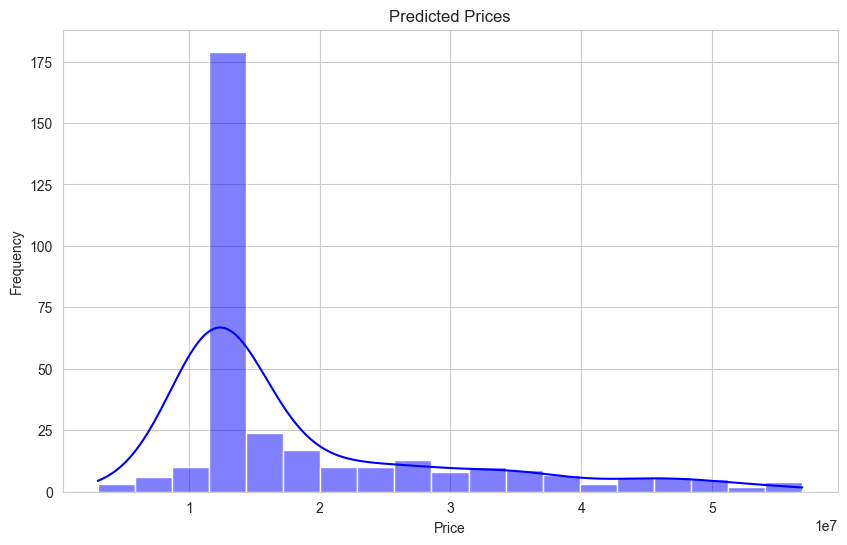

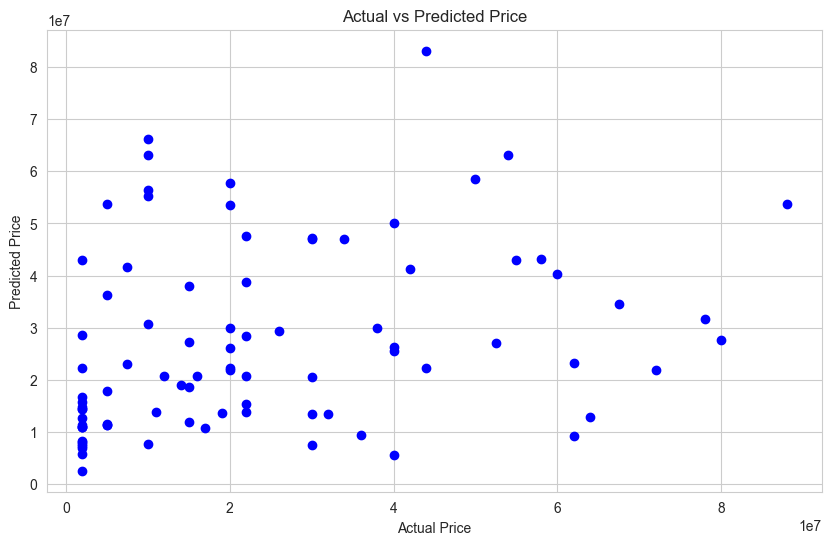

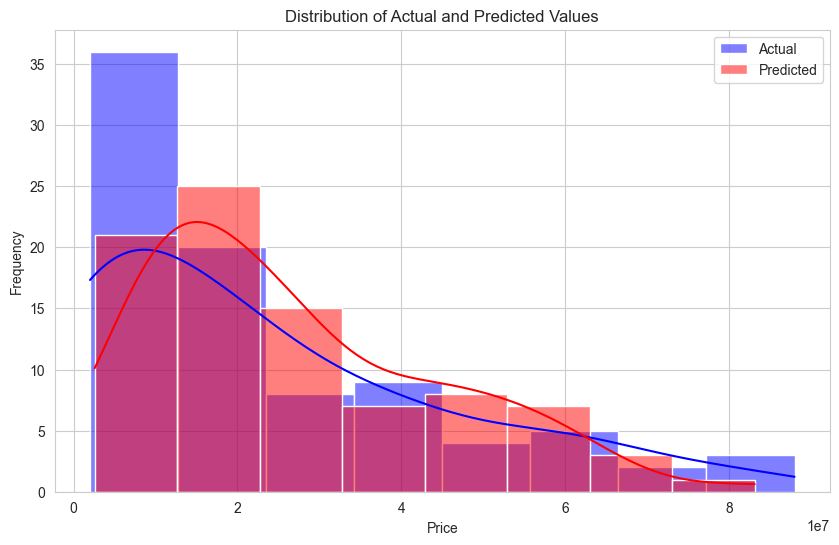

In [43]:
# Plot the predictions
plt.figure(figsize=(10, 6))
sns.histplot(predictions, color='blue', kde=True)
plt.title('Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Actual vs Predicted Prices for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, color='blue')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# Distribution of the actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True)
sns.histplot(preds, color='red', label='Predicted', kde=True)
plt.title('Distribution of Actual and Predicted Values')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [44]:
import optuna
import xgboost as xgb

#objective function for the optuna study
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eta': trial.suggest_loguniform('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_uniform('gamma', 0, 0.5),
        'lambda': trial.suggest_loguniform('lambda', 0.01, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 0.01, 10.0)
    }
    
    #initialize and train the model with initial parameters
    xgb_model = xgb.XGBRegressor(n_estimators=100, **params)
    xgb_model.fit(x_train, y_train)

    #make predictions for the validation set
    preds = xgb_model.predict(x_val)

    #calculate rmse - obj value to be minimized
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best parameters found: ", study.best_params)
print("Lowest RMSE found: ", study.best_value)

# Train the final model with the best parameters
best_params = study.best_params
best_model = xgb.XGBRegressor(n_estimators=100, **best_params)
best_model.fit(x_train, y_train)

# Predictions and RMSE
predictions = best_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {rmse}')


[I 2024-06-17 12:20:53,695] A new study created in memory with name: no-name-e77af13b-0e1d-44d7-a6ea-707840e6385d
[I 2024-06-17 12:20:54,291] Trial 0 finished with value: 26206648.0 and parameters: {'eta': 0.09823798827338724, 'max_depth': 9, 'subsample': 0.8492224174240617, 'colsample_bytree': 0.8572139144936686, 'min_child_weight': 9, 'gamma': 0.27701225892425024, 'lambda': 0.12033210033273617, 'alpha': 0.017863089063913457}. Best is trial 0 with value: 26206648.0.
[I 2024-06-17 12:20:54,730] Trial 1 finished with value: 26569658.0 and parameters: {'eta': 0.1060054754328743, 'max_depth': 5, 'subsample': 0.7788438745964325, 'colsample_bytree': 0.8418459873005528, 'min_child_weight': 1, 'gamma': 0.38639277319391635, 'lambda': 1.5193816084311742, 'alpha': 0.18651069405942705}. Best is trial 0 with value: 26206648.0.
[I 2024-06-17 12:20:55,332] Trial 2 finished with value: 25996886.0 and parameters: {'eta': 0.0261144912843799, 'max_depth': 9, 'subsample': 0.9272481095205262, 'colsample_b

KeyboardInterrupt: 